In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric, poisson, exponential
from scipy.stats import ks_2samp
from scipy.stats import norm,poisson
from numpy import linspace
from IPython.display import Markdown
from analysis import *

---------------------
Trx = 10
---------------------


<span style="color: #9a0000">P(S) = 0.769435</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.230565</span>

---------------------
Trx = 11
---------------------


<span style="color: #9a0000">P(S) = 0.785671</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.214329</span>

---------------------
Trx = 12
---------------------


<span style="color: #9a0000">P(S) = 0.800099</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.199901</span>

---------------------
Trx = 13
---------------------


<span style="color: #9a0000">P(S) = 0.812676</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.187324</span>

---------------------
Trx = 14
---------------------


<span style="color: #9a0000">P(S) = 0.823491</span>

<span style="color: #009a00">P(N) = 0.000001</span>

<span style="color: #00009a">P(B) = 0.176508</span>

---------------------
Trx = 15
---------------------


<span style="color: #9a0000">P(S) = 0.833262</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.166738</span>

---------------------
Trx = 16
---------------------


<span style="color: #9a0000">P(S) = 0.842318</span>

<span style="color: #009a00">P(N) = 0.000001</span>

<span style="color: #00009a">P(B) = 0.157681</span>

---------------------
Trx = 17
---------------------


<span style="color: #9a0000">P(S) = 0.849919</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.150081</span>

---------------------
Trx = 18
---------------------


<span style="color: #9a0000">P(S) = 0.857312</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.142688</span>

---------------------
Trx = 19
---------------------


<span style="color: #9a0000">P(S) = 0.863821</span>

<span style="color: #009a00">P(N) = 0.000000</span>

<span style="color: #00009a">P(B) = 0.136179</span>

---------------------


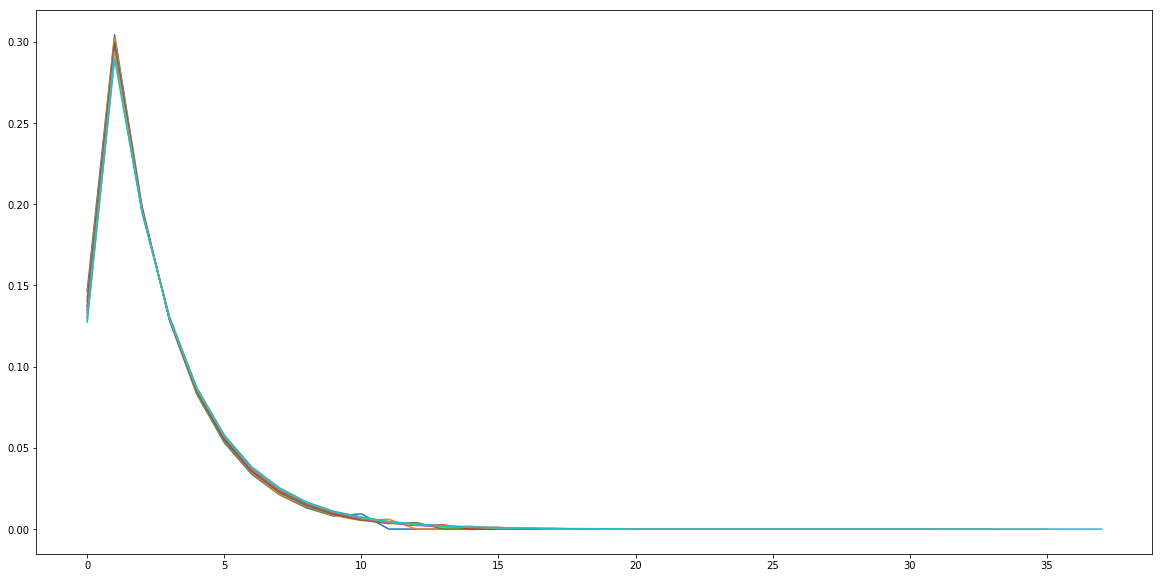

In [2]:
print('---------------------')#just for graphics
for i in range(2,22,2):
    f1 = open("r%d-d0-result.txt"%i)
    raw1 = f1.read()
    f1.close()
    f2 = open("r%d-d1-result.txt"%i)
    raw2 = f2.read()
    f2.close()
    Ttx = 1
    Trx = i
    Tn = 1

    Eb,Es,En = computeEvents(raw1,Ttx,Trx,Tn)
    print("Trx = %d"%i)
    print('---------------------')
    display(Markdown('<span style="color: #9a0000">'+"P(S) = %.6f"%(Trx*Es/len(raw1))+'</span>'))
    display(Markdown('<span style="color: #009a00">'+"P(N) = %.6f"%(Tn*En/len(raw1))+'</span>'))
    display(Markdown('<span style="color: #00009a">'+"P(B) = %.6f"%(Ttx*Eb/len(raw1))+'</span>'))
    print('---------------------')
    Cb1 = countBroadcast(raw2,raw1,Trx,Ttx)

    hist1 = buildHistogram(Cb1,Trx,Ttx)
    pt.rcParams["figure.figsize"] = (20,10)
    pt.plot(range(len(hist1)),hist1,label='Trx= %d'%i)
    
pt.show()
    